In [1]:
# Useful Links
# 1. https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
# 2. https://machinelearningknowledge.ai/keras-implementation-of-resnet-50-architecture-from-scratch/
# 3. https://towardsdatascience.com/resnets-for-cifar-10-e63e900524e0 (Understanding the resnet architecture for cifar10)


In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import warnings
warnings.filterwarnings(action="ignore")

In [3]:
# Load necessary libraries
import os
import pandas as pd
import numpy as np
#import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
#from google.colab.patches import cv2_imshow
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D,Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import glorot_uniform
from matplotlib import pyplot as plt
from tensorflow.keras.utils import to_categorical



In [4]:
def load_dataset(dName="CIFAR10"):
    dataset = None
    if dName == "CIFAR10":
        dataset = tf.keras.datasets.cifar10.load_data()
    if dName == "CIFAR100":
        dataset = tf.keras.datasets.cifar100.load_data()
    (X_train, y_train), (X_test, y_test) = dataset
    # Convert target value to categorical values
    # One-hot-encoded target values
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    
    return (X_train, y_train),(X_test, y_test)

In [5]:
def describeDataset(X_train, y_train, X_test, y_test):
    print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
    print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))

In [6]:
def displayImage(images=None):
    if images.any():
        # Plot a few images
        for i in range(9):
            plt.subplot(330+1+i)
            plt.imshow(images[i])
        plt.show()
    else:
        print('Error! File is empty')

In [7]:
def normalizeInput(X_train,X_test):
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train = X_train/255.0
    X_test = X_test/255.0
    
    return X_train, X_test

In [8]:
## This is just for testing preprocessing steps
def defineModel(classes=10):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.4))
    model.add(Dense(classes, activation='softmax'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [9]:
# plot diagnostic learning curves
def plotLearningCurve(history):
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    plt.show()
    plt.close()

In [10]:
(X_train, y_train),(X_test, y_test) = load_dataset('CIFAR100')
describeDataset(X_train,y_train,X_test,y_test)

Train: X=(50000, 32, 32, 3), y=(50000, 100)
Test: X=(10000, 32, 32, 3), y=(10000, 100)


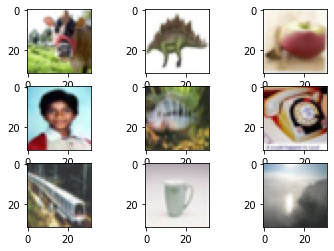

In [11]:
displayImage(X_train) # Need to pass a numpy array

In [12]:
X_train, X_test = normalizeInput(X_train, X_test)

In [ ]:
model = defineModel(y_train.shape[1])
history = model.fit(X_train,y_train,epochs=100, batch_size=64, validation_data=(X_test, y_test), verbose=2)

Epoch 1/100


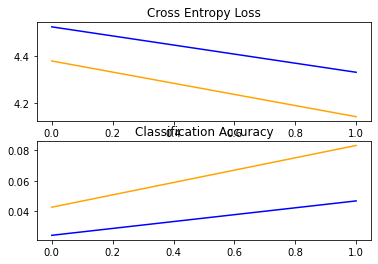

In [14]:
plotLearningCurve(history)

# ResNet Implementation

In [15]:
def identityBlock(X, f, filters, stage, block):
    k_initializer = glorot_uniform(seed=0)
    conv_name = 'res'+str(stage)+block+'_branch'
    bat_name = 'bn'+str(stage)+block+'_branch'
    
    F1, F2, F3 = filters
    
    X_skip = X
    
    X = Conv2D(filters=F1,kernel_size=(1,1),strides =(1,1),padding='valid',name=conv_name+'2a',
              kernel_initializer=k_initializer)(X)
    X = BatchNormalization(axis=3,name=bat_name+'2a')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters=F2, kernel_size=(f,f),strides=(1,1),padding='same',name=conv_name+'2b',
              kernel_initializer=k_initializer)(X)
    X = BatchNormalization(axis=3,name=bat_name+'2b')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters=F3,kernel_size=(1,1),strides=(1,1),padding='valid',name=conv_name+'2c',
              kernel_initializer=k_initializer)(X)
    X = BatchNormalization(axis=3,name=bat_name+'2c')(X)
    
    X = Add()([X,X_skip])
    X = Activation('relu')(X)
    
    return X

In [16]:
def convolutionalBlock(X, f, filters, stage, block, s=2):
    k_init = glorot_uniform(seed=0)
    conv_name = 'res'+str(stage)+block+'_branch'
    bat_name = 'bn'+str(stage)+block+'_branch'
    
    F1, F2, F3 = filters
    
    X_skip = X
    
    X = Conv2D(filters=F1,kernel_size=(1,1),strides=(s,s),name=conv_name+'2a',kernel_initializer=k_init)(X)
    X = BatchNormalization(axis=3,name=bat_name+'2a')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters=F2, kernel_size=(f,f),strides=(1,1),padding='same', name=conv_name+'2b',kernel_initializer=k_init)(X)
    X = BatchNormalization(axis=3,name=bat_name+'2b')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters=F3, kernel_size=(1,1),strides=(1,1),padding='valid',name=conv_name+'2c',kernel_initializer=k_init)(X)
    X = BatchNormalization(axis=3,name=bat_name+'2c')(X)
    
    X_skip = Conv2D(filters=F3,kernel_size=(1,1),strides=(s,s), padding='valid',name=conv_name+'1',
                   kernel_initializer=k_init)(X_skip)
    X_skip = BatchNormalization(axis=3,name=bat_name+'1')(X_skip)
    
    X = Add()([X, X_skip])
    X = Activation('relu')(X)
    
    return X
    

In [17]:
def ResNet50(input_shape=(64,64,3), classes=6):
    
    X_input = Input(input_shape)
    X = ZeroPadding2D((3,3))(X_input)
    
    
    X = Conv2D(64,kernel_size=(7,7),strides=(2,2),name='conv1',kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3,name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3,3),strides=(2,2))(X)
    
    X = convolutionalBlock(X, f=3, filters=[64,64,256],stage=2,block='a',s=1)
    X = identityBlock(X,3,[64,64,256],stage=2,block='b')
    X = identityBlock(X,3,[64,64,256],stage=2,block='c')
    
    
    X = convolutionalBlock(X, f=3, filters=[128,128,512],stage=3,block='a',s=2)
    X = identityBlock(X,3,[128,128,512],stage=3,block='b')
    X = identityBlock(X,3,[128,128,512],stage=3,block='c')
    X = identityBlock(X,3,[128,128,512],stage=3,block='d')
   
    
    X = convolutionalBlock(X, f=3, filters=[256,256,1024],stage=4,block='a',s=2)
    X = identityBlock(X,3,[256,256,1024],stage=4,block='b')
    X = identityBlock(X,3,[256,256,1024],stage=4,block='c')
    X = identityBlock(X,3,[256,256,1024],stage=4,block='d')
    X = identityBlock(X,3,[256,256,1024],stage=4,block='e')
    X = identityBlock(X,3,[256,256,1024],stage=4,block='f')
    
    
    
    X = convolutionalBlock(X, f=3, filters=[512,512,2048],stage=5,block='a',s=2)
    X = identityBlock(X,3,[512,512,2048],stage=5,block='b')
    X = identityBlock(X,3,[512,512,2048],stage=5,block='c')
    
    
    X = AveragePooling2D((2,2),name='avg_pool')(X)
    
    X = Flatten()(X)
    X = Dense(classes, activation='softmax',name='fc'+str(classes),kernel_initializer=glorot_uniform(seed=0))(X)
    
    model = Model(inputs=X_input,outputs=X, name='LResNet50')
    
    return model

In [18]:
model = ResNet50(input_shape=(64,64,3),classes=10)

In [19]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
history = model.fit(X_train,y_train,epochs=2, batch_size=64, validation_data=(X_test, y_test), verbose=0)

ValueError: in user code:

    /Users/ldas/miniforge3/envs/advML/lib/python3.8/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /Users/ldas/miniforge3/envs/advML/lib/python3.8/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/ldas/miniforge3/envs/advML/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/ldas/miniforge3/envs/advML/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/ldas/miniforge3/envs/advML/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/ldas/miniforge3/envs/advML/lib/python3.8/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /Users/ldas/miniforge3/envs/advML/lib/python3.8/site-packages/keras/engine/training.py:787 train_step
        y_pred = self(x, training=True)
    /Users/ldas/miniforge3/envs/advML/lib/python3.8/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Users/ldas/miniforge3/envs/advML/lib/python3.8/site-packages/keras/engine/input_spec.py:266 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer LResNet50: expected shape=(None, 64, 64, 3), found shape=(None, 32, 32, 3)
